AdamW/SGDW benchmarking

In [45]:
PATH = 'C:/input/cifar10/cifar_class'

In [46]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [47]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
def Get_SGD_Momentum(momentum=0.9):
    return lambda *args,**kwargs: optim.SGD(*args,momentum=momentum,**kwargs)

def Get_Adam():
    return lambda *args,**kwargs: optim.Adam(*args,**kwargs)

In [49]:
import pickle

def save_list(fname,l):
    with open(fname,"wb") as fp:
        pickle.dump(l,fp)

def read_list(fname):
    with open(fname,"rb") as fp:
        return pickle.load(fp)

In [50]:
#Section 1: Plot loss trends of various scenarios

In [77]:
def experiment(optimizer,PATH,lr=1e-3,find_lr=False,use_wd_sched=False,wds=None,do_unfreeze=False,
               norm_wds=False,wds_sched_mult=None):
    sz = 32
    bs = 120
    arch = resnet152
    cycle_len = 2
    cycle_mult = 2
    num_cycles = 4
    lr = lr
    
    if wds is None:
        weight_decay =0.025
    else:
        weight_decay = wds
    
    tfms = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
    #data = ImageClassifierData.from_paths(PATH,tfms=tfms,bs=bs)
    data = ImageClassifierData.from_paths(PATH,tfms=tfms,bs=bs,val_name='test')
    learn = ConvLearner.pretrained(arch,data,precompute=True,xtra_fc=[1024,512],opt_fn=optimizer)
    
    if find_lr:
        lrf = learn.lr_find()
        learn.sched.plot()
        return
    
    learn.fit(lr,1,wds=weight_decay,use_wd_sched=use_wd_sched,norm_wds=norm_wds,wds_sched_mult=wds_sched_mult)
    print('Now with precompute as False')
    if do_unfreeze:
        learn.unfreeze()
    
    learn.precompute=False
    learn.fit(lr,num_cycles,wds=weight_decay,use_wd_sched=use_wd_sched,cycle_len=cycle_len,
              cycle_mult=cycle_mult,norm_wds=norm_wds,wds_sched_mult=wds_sched_mult)
    
    loss = learn.sched.losses
    fig = plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.show()
    learn.sched.plot_lr()
    
    return learn.sched.losses,learn

In [70]:
f = lambda x:np.array(x.layer_opt.lrs) / x.init_lrs

In [71]:
# SGDR/SGDW

Wall time: 0 ns
 88%|█████████████████████████▌   | 368/417 [00:37<00:04,  9.89it/s, loss=4.89]

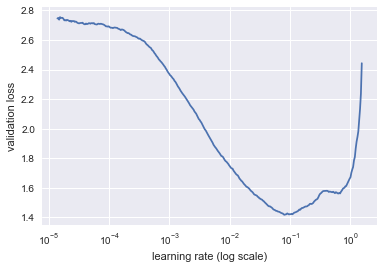

In [72]:
%time
sgdm = Get_SGD_Momentum()
loss_sgdm = experiment(sgdm,PATH=PATH,find_lr=True)

Train

In [78]:
%%time
# Without weight decay
sgdm = Get_SGD_Momentum()
loss_sgdm, _ = experiment(sgdm, PATH=PATH, lr=1e-2)
save_list('sgdm_loss.txt', loss_sgdm)

epoch      trn_loss   val_loss   accuracy   
    0      1.073901   1.029617   0.654     

Now with precompute as False
epoch      trn_loss   val_loss   accuracy   
    0      1.115785   1.011541   0.6656    
    1      1.04774    0.955619   0.6851    
    2      1.156722   1.070934   0.6472    
    3      1.111944   1.005903   0.6678    
    4      1.062487   0.956045   0.6845    
    5      1.012594   0.930301   0.6929    
    6      1.152739   1.066976   0.644     
    7      1.148811   1.03438    0.6553    
    8      1.127418   1.047589   0.6534    
    9      1.12145    1.030772   0.6524    
    10     1.101631   0.999229   0.6704    
    11     1.062633   0.961854   0.686     
    12     1.012815   0.936684   0.6949    
    13     1.004065   0.932104   0.696     
    14     1.159917   1.076503   0.6422    
    15     1.17264    1.074827   0.642     
    16     1.17998    1.07522    0.6408    
    17     1.181298   1.088801   0.6333    
    18     1.157901   1.062441   0.6466    


KeyboardInterrupt: 

In [ ]:
%%time
# With weight decay
adamw = Get_Adam()
loss_adamw, _ = experiment(adamw, PATH, 1e-3, use_wd_sched=True, norm_wds=True, wds_sched_mult=f)
save_list('adamw_loss.txt', loss_adamw)

In [ ]:
# Differential Learning and Weight Decay

In [ ]:
%%time
adamw_diff = Get_Adam()
lr = 1e-3
wd = 0.025
loss_adamw_diff, _ = experiment(adamw_diff, PATH, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_sched=True, norm_wds=True, wds_sched_mult=f)
save_list('loss_adamw_diff.txt', loss_adamw_diff)

In [ ]:
%%time
sgdw_diff = Get_SGD_Momentum(0.9)
lr = 1e-2
wd = 0.025
loss_sgdw_diff, _ = experiment(sgdw_diff, PATH, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_sched=True, norm_wds=True, wds_sched_mult=f)
save_list('loss_sgdw_diff.txt', loss_sgdw_diff)

In [ ]:
fig=plt.figure(figsize=(15, 10))
plt.plot(loss_adam, c='red', label='Adam')
plt.plot(loss_sgdm, c='blue', label='SGDM')
plt.plot(loss_adamw, c='green', label='AdamW')
plt.plot(loss_sgdmw, c='black', label='SGDW')
plt.plot(loss_adamw_diff, c='orange', label='AdamW_differential')
plt.plot(loss_sgdw_diff, c='gray', label='SGDW_differential')
plt.legend()
plt.show()

In [ ]:
#Section 2: Check for regularization of overfitting

In [ ]:
import time

In [ ]:
def check_overfitting(optimizer,PATH,sz,bs,lr,wds,use_wd_sched=True):
    arch=resnet50
    cycle_len=12
    cycle_mult=2
    num_cycles=1
    
    tfms = tfms_from_model(arch,sz)
    data = ImageClassifierData.from_paths(PATH,tfms=tfms,bs=bs)
    # turning off Dropout, adding 3 extra FC layers to help in overfitting.
    learn = ConvLearner.pretrained(arch,data,precompute=False,xtra_fc=[1024,512],ps=[0,0,0],opt_fn=optimizer)
    
    print("==== Let's overfit the model. Expectation: training loss should reduce but validation loss should stagnate.")
    learn.unfreeze()
    learn.fit(lr, num_cycles, cycle_len=cycle_len, cycle_mult=cycle_mult)
    print("==== Let's introduce weight regularization. Expectation: training loss and validation loss should reduce. Accuracy should improve.")
    learn.fit(lr, num_cycles, wds=wds, use_wd_sched=use_wd_sched, cycle_len=cycle_len, cycle_mult=cycle_mult)
    time.sleep(5)
    

In [ ]:
%%time
PATH = "/home/as/datasets/fastai.dogscats/"
check_overfitting(Get_Adam(), PATH=PATH, sz=224, bs=96, lr=1e-3, wds=0.25, use_wd_sched=True)

In [ ]:
%%time
PATH = 'C:/input/cifar10/cifar_class'
check_overfitting(Get_Adam(), PATH=PATH, sz=32, bs=320, lr=1e-3, wds=0.45, use_wd_sched=True)

In [ ]:
%%time
PATH = 'C:/input/cifar10/cifar_class'
check_overfitting(Get_Adam(), PATH=PATH, sz=32, bs=320, lr=1e-3, wds=0.45, use_wd_sched=False)

In [ ]:
# Separate weight regularization

In [ ]:
%%time
# With weight decay
adamw = Get_Adam()
lr = [1e-5,1e-4,1e-3]
wd = [1e-7,1e-6,1e-5]
loss_adamw1, learn1 = experiment(adamw, PATH, lr, use_wd_sched=True, wds=wd, do_unfreeze=True)
save_list('adamw_loss1.txt', loss_adamw1)

In [ ]:
%%time
# With weight decay
adamw = Get_Adam()
lr = [1e-5,1e-4,1e-3]
wd = [1e-5,1e-4,1e-3]
loss_adamw2, learn2 = experiment(adamw, PATH, lr, use_wd_sched=True, wds=wd, norm_wds=True, do_unfreeze=True)
save_list('adamw_loss2.txt', loss_adamw2)

In [ ]:
%%time
# With weight decay
adamw = Get_Adam()
lr = [1e-5,1e-4,1e-3]
wd = [1e-5,1e-4,1e-3]
f = lambda x: np.array(x.layer_opt.lrs) / x.init_lrs
loss_adamw3, learn3 = experiment(adamw, PATH, lr, use_wd_sched=True, wds=wd, norm_wds=True, wds_sched_mult=f, do_unfreeze=True)
save_list('adamw_loss3.txt', loss_adamw3)

In [ ]:
fig = plt.figure(figsize=(15, 10))
plt.plot(loss_adamw1)
plt.plot(loss_adamw2)
plt.plot(loss_adamw3)
plt.show()

In [ ]:
%%time
# With weight decay
adamw = Get_Adam()
lr = [1e-5,1e-4,1e-3]
wd = [1e-5,1e-4,1e-3]
loss_adamw4, learn4 = experiment(adamw, PATH, lr, use_wd_sched=True, wds=wd, do_unfreeze=True)
save_list('adamw_loss4.txt', loss_adamw4)